In [1]:
#purpose is to take in images, reproject and cut them out if needed, first collecting some files
'''
Paths and file needs:
*imglams and spitzer_conversions are excel files, right now I have it so you need to put it as same directory as your code (but could later maybe just give it a path to go to - would be smarter)
*paths to images and data in general (e.g. from the MAST archive, drizzlepac pipeline, etc)
'''
#now the steps
'''
1) read in all the data by noting all the paths to the continuum subtracted hst images
2) loop through all the data, read it in, convert units
(optional) 3) cutout all the data as appropriate
3) reprojecting all the data with your favorite tool (e.g. ipac montage, tweakreg, drizzlepac, etc). 
4) save all the images in a neat fashion if you can
'''

#just to check python version - should be 3.8.13
from platform import python_version
print(python_version())

#importing libraries
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.io import fits
from astropy.wcs import WCS
import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

#this part is unnecessary...in jupyter...but if you're scripting and want to test blocks of code
#you may want switches, EX:
# switch1 = 'on' #convolving images [needed to put it on for switch 3 at min...need to figure out other solution, eh]
# switch1b = 'on' #regridding...
# switch2 = 'on' #solving equations
# switch3 = 'on' #plotting / graphics of solutions

3.8.13


In [2]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


#if you want to convolve an image, I have the example below
'''now convolve my image with a PSF of the image we're projecting ONTO
an approx PSF can be found by assuming a 2D Gaussian func with a width (a FWHM) of the diffrac limit
that is the st dev of the Gaussian is about the st dev is about = lambda/D
a list of PSFs are found on https://docs.astropy.org/en/stable/convolution/kernels.html

Notes:
FIRST: always must convert hdu1_pixtorad to radians! It's inconsistent otherwise, and lambda/D is generally in radians

what we're using for the gaussian width is the FWHM, not the radius of the first ring of the diffraction pattern,
so it's 1.2 not 1.22 times lambda/D

D is 85 cm for spitzer
D is 2.4 m for hubble
'''
def im_conv(low_res_name, D, hdu_pix_torad, hdu_dat, kern):
    #unfortuantely no good way to find wavelength from header right now. can enter it manually, but I tried to automate it

    #reading in excel file of wavelengths...right now needs to be in same directory as this code
    #first col is a substring of the fits image file name, the second col is the wavelengths in microns
    df = pd.read_excel('imglams.xlsx')
    cols = df.columns
    cols_str = [str(i) for i in df[cols[0]]]
    #some test cases I was using

    #gaussian kernel
    if kern == 'gauss':
        #this finds the loc in the excel file where the image substring matches our image name
        #it then finds the wavelength value corresponding to that loc
        lam =  df.loc[np.where([i in low_res_name for i in cols_str])[0][0]].values[1] #lambda in microns

        #finding angular resolution...the FWHM of our Gaussian PSF
        res = 1.2 * lam / D         #resolution in radians
        res = res / hdu_pix_torad        #so converting to pixels

        #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
        kernel = Gaussian2DKernel(res)

    #box kernel
    if kern == 'box':
        kernel = Box2DKernel(16.)

    hdu_conv = convolve(hdu_dat, kernel)
    return hdu_conv



#a new fits file to be saved and viewed in DS9
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
    #saving the file
    if name.find('FIT') == -1: #needed if file end incorrect
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
    else:
        name_fixfit = name[:-3] + 'fits'
        new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
        
    return (save_path+new_filename)

In [3]:
#here, we're trying to load in our images in whatever way you want

#if applying montage to images on inanna, start here but use:
path = '../../drizzle_ngc2071/simult_tweakreg_default/*drz*'
# inanna_path =
# path = '../../drizzle_ngc2071/*.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
im_names_n2071 = im_name_finder(path, 'fit') #im_finder is basically glob.glob
im_names_n2071 = sorted([i.replace('\\', '/') for i in im_names_n2071])[:-1]

In [4]:
im_names_n2071 #checking we have them all

['../../drizzle_ngc2071/simult_tweakreg_default/126n_thresh100_cw3.5_combined_drz.fits',
 '../../drizzle_ngc2071/simult_tweakreg_default/128n_thresh100_cw3.5_combined_drz.fits',
 '../../drizzle_ngc2071/simult_tweakreg_default/130n_thresh100_cw3.5_combined_drz.fits',
 '../../drizzle_ngc2071/simult_tweakreg_default/160w_thresh100_cw3.5_combined_drz.fits',
 '../../drizzle_ngc2071/simult_tweakreg_default/164n_thresh100_cw3.5_combined_drz.fits']

1.2584887
1.2831845
1.300568


C:\Users\arubi\AppData\Local\Temp\ipykernel_3352\2432948839.py:50: RuntimeWarning: invalid value encountered in sqrt
  ston = np.sqrt((hdu_data[1].data * hdu_data[2].data)) #elec/s * sec = N_elec?
C:\Users\arubi\AppData\Local\Temp\ipykernel_3352\2432948839.py:51: RuntimeWarning: divide by zero encountered in true_divide
  hdu_err_list.append(hdu_data[1].data / ston * hdu_data[0].header['PHOTFLAM'] * hdu_data[0].header['PHOTBW'])


1.5369176
1.6403508000000002
[0.1282500028610229, 0.1282500028610229, 0.1282500028610229, 0.1282500028610229, 0.1282500028610229]


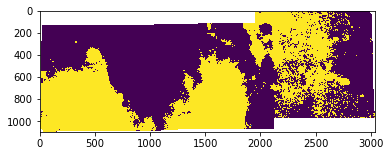

In [5]:
hdu_list = ([fits.open(i) for i in im_names_n2071])

#how to produce error images...
#need to loop through all the hdu_lists, multiply them together, and save them to be montaged (see below)
'''
https://hst-docs.stsci.edu/wfc3dhb/chapter-2-wfc3-data-structure/2-2-wfc3-file-structure
the science image (SCI),
the error array (ERR),
the data quality array (DQ),
the number of samples array (SAMP), and
the integration time array (TIME).
'''
plt.imshow(hdu_list[0][1].data * hdu_list[0][2].data, vmin=1e-17, vmax=1e-16)


#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
# hdu_fnu_list = []
hdu_lam_list = []
# hdu_flam_list = []
hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []
hdu_err_list = []

#adding something at the start (or end) of each file to distinguish them
file_start = './flam_'
file_err_start = './flam_err'
flam_path_list = [] #list of paths to the convolved images, can be useful...
flam_err_path_list = []

#looping through data, designed here for HST
count = 0
for hdu_data in hdu_list:   
    #reading in conversions
    hdu_pix_list.append(hdu_data[0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
    hdu_pixtorad_list.append(hdu_pix_list[count] / 206265.)
    hdu_lam_list.append(hdu_data[0].header['PHOTFLAM'])
    hdu_bw_list.append(hdu_data[0].header['PHOTBW'])
    print(hdu_data[0].header['PHOTPLAM']/1e4)

    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    hdu_data_list.append(hdu_data[1].data * hdu_data[0].header['PHOTFLAM'] * hdu_data[0].header['PHOTBW'])
    hdu_header_list.append(hdu_data[1].header)
    
    #computing uncert image, based on 1/sqrt(N_electrons)
#     http://astro.physics.uiowa.edu/~kaaret/2018s_a4850/Lab03_snr.html
    ston = np.sqrt((hdu_data[1].data * hdu_data[2].data)) #elec/s * sec = N_elec?
    hdu_err_list.append(hdu_data[1].data / ston * hdu_data[0].header['PHOTFLAM'] * hdu_data[0].header['PHOTBW'])
    
    #saving each file to some path, editing the 'HISTORY' card to make a note
    hdu_data[1].header['HISTORY'] = 'Image was processed with drizzlepac, and units were converted. Units are all CGS (ergs/s/cm^2).'  #adding history keyword so we know what we did to this image
#     w = WCS(hdu_data[1].header)
#     flam_path = fits_saver(hdu_data_list[count], hdu_data[1].header, im_names_n2071[count], file_start)
#     flam_path_list.append(flam_path)
    flam_err_path = fits_saver(hdu_err_list[count], hdu_data[1].header, im_names_n2071[count], file_err_start)
    flam_err_path_list.append(flam_err_path)    
    count+=1

print(hdu_pix_list)

In [6]:
'''
sample script to run with montage...this time applied to NGC 2071
see http://montage.ipac.caltech.edu/MontageNotebooks/Mosaic.html
or http://montage.ipac.caltech.edu/MontageNotebooks/ for details
In general, I try to have setup a montage_metadata and diffs folder with temp files

first before doing anything you need to have 3 folders with labels including
raw, projected, and corrected

afterwards, fill the folder containing "raw" with your input fits files, then proceed...
'''
from MontagePy.main import mHdr, mMakeHdr, mGetHdr, mImgtbl, mProjExec

#the first lines here are just setting up the raw images and projection
# size = 0.5 #this is in degrees?
# rtn = mHdr('NGC 2071', size, size, "montage_metadata/region.hdr")

# https://github.com/Caltech-IPAC/Montage/issues/7 avoid spaces in paths and be careful about slashes for directories
#here we try to project the epoch2 images onto the epoch 1 (better overlap)
rtn = mGetHdr('raw_n2071_headercut/wcsonly_megeath_combined_drz.fits', 'montage_metadata/n2071_hdr.hdr') #need to change hdu depending on where wcs info is indexed in your header
rtn = mImgtbl("raw_n2071_headercut", "montage_metadata/rimages.tbl") #important, no / here for the raw directory...
rtn = mProjExec("raw_n2071_headercut/", "montage_metadata/rimages.tbl", "montage_metadata/n2071_hdr.hdr", projdir="projected_n2071_headercut")

#and here we are trying to proejct all the wide-field mosaics to have the same wcs
rtn = mGetHdr('raw_n2071_simult_tweak_reg_flam/flam_164n_thresh100_cw3.5_combined_drz.fits', 'montage_metadata/n2071_simult_hdr.hdr') #need to change hdu depending on where wcs info is indexed in your header
rtn = mImgtbl("raw_n2071_simult_tweak_reg_flam", "montage_metadata/rimages.tbl") #important, no / here for the raw directory...
rtn = mProjExec("raw_n2071_simult_tweak_reg_flam", "montage_metadata/rimages.tbl", "montage_metadata/n2071_simult_hdr.hdr", projdir="projected_n2071_simult_tweak_reg_flam/")

#tries to rotate the 160w image onto the other images, ends with a worse product...
# rtn = mGetHdr('raw_n2071_cropping/hdu0_flam_126n_thresh100_cw3.5_combined_drz.fits', 'montage_metadata/n2071_cropped_hdr.hdr') #need to change hdu depending on where wcs info is indexed in your header
# rtn = mImgtbl("raw_n2071_cropping", "montage_metadata/rimages.tbl") #important, no / here for the raw directory...
# rtn = mProjExec("raw_n2071_cropping", "montage_metadata/rimages.tbl", "montage_metadata/n2071_simult_hdr.hdr", projdir="projected_n2071_cropping/")


'''
if say you wanted diff images, you could do something like

from MontagePy.main import mDiff, mOverlaps, mDiffFitExec, mBgModel, mBgExec
projected_images = glob.glob('projected_n2071_headercut/*drz.fits')
mDiff(projected_images[0], projected_images[1], 'diffs_n2071_headercut/diff_160_167', 'montage_metadata/n2071_hdr.hdr')
mDiff(projected_images[0], projected_images[2], 'diffs_n2071_headercut/diff_160_164', 'montage_metadata/n2071_hdr.hdr')

If you have many images and don't want to do it by hand, mDiffExec is probably something you could use, or you could otherwise just loop this

#this set of lines is to give an option for background correction
# rtn = mImgtbl("corrected_noscale", "montage_metadata/cimages.tbl")
# rtn = mOverlaps("montage_metadata/pimages.tbl", "diffs/diffs.tbl")
# rtn = mDiffFitExec("projected_noscale", "diffs/diffs.tbl", "montage_metadata/fixed_spitzer_hdr.hdr", "diffs", "diffs/fits.tbl")
# rtn = mBgModel("montage_metadata/pimages.tbl", "diffs/fits.tbl", "diffs/corrections.tbl")
# rtn = mBgExec("projected_noscale", "montage_metadata/pimages.tbl", "diffs/corrections.tbl", "corrected_noscale")
# rtn = mImgtbl("corrected_noscale", "montage_metadata/cimages.tbl")
'''


#for the case of rotating...#here we try to project the epoch2 images onto the epoch 1 (better overlap)
'''
the primary ways to do this follow 
https://stackoverflow.com/questions/51952436/plotting-sdss-images-with-python/51967697#51967697
or https://astronomy.stackexchange.com/questions/48827/align-an-image-to-celestial-north
basically using montage-wrapper reproject with north_align = True
OR in the more recent MontagePy, we can use mMakeHdr, then we must make an Imgtbl first...
'''
rtn = mImgtbl("raw_n2071_header_megeath", "montage_metadata/rimages.tbl") #important, no / here for the raw directory...
rtn = mMakeHdr("montage_metadata/rimages.tbl", "montage_metadata/region.hdr", northAligned=1) #need to first make a header with rotation
'''
here, you want to take a step to directly edit the hdr, for example in txt or with code
you're looking to change either or both of the ORIENTAT, ROTA1, ROTA2, and CD1_1, etc cards...
my main recommendation is to change the name of the header after these first two steps and before running the next one
'''
rtn = mImgtbl("raw_n2071_headercut", "montage_metadata/rimages.tbl") #important, no / here for the raw directory...
rtn = mProjExec("raw_n2071_headercut/", "montage_metadata/rimages.tbl", "montage_metadata/region.hdr", projdir="projected_n2071_headercut_rotated")

#need to perform this again because the cropping isn't the same...
rtn = mGetHdr('projected_n2071_headercut_rotated/hdu0_wcsonly_megeath_combined_drz.fits', 'montage_metadata/n2071_hdr.hdr') #need to change hdu depending on where wcs info is indexed in your header
rtn = mImgtbl("projected_n2071_headercut_rotated", "montage_metadata/rimages.tbl") #important, no / here for the raw directory...
rtn = mProjExec("projected_n2071_headercut_rotated/", "montage_metadata/rimages.tbl", "montage_metadata/n2071_hdr.hdr", projdir="projected_n2071_headercut_rotated_cropped")

#######################################################...

#and here we are trying to proejct all the wide-field mosaics to have the same wcs
rtn = mImgtbl("raw_n2071_header_epoch2", "montage_metadata/rimages.tbl") #important, no / here for the raw directory...
rtn = mMakeHdr("montage_metadata/rimages.tbl", "montage_metadata/region.hdr", northAligned=1) #need to first make a header with rotation
rtn = mImgtbl("raw_n2071_epoch2_mosaics", "montage_metadata/rimages.tbl") #important, no / here for the raw directory...
rtn = mProjExec("raw_n2071_epoch2_mosaics/", "montage_metadata/rimages.tbl", "montage_metadata/region.hdr", projdir="projected_n2071_epoch2_mosaics")

#need to perform this again because the cropping isn't the same...
rtn = mGetHdr('projected_n2071_epoch2_mosaics/hdu0_flam_err126n_thresh100_cw3.5_combined_drz.fits', 'montage_metadata/n2071_hdr.hdr') #need to change hdu depending on where wcs info is indexed in your header
rtn = mImgtbl("projected_n2071_epoch2_mosaics", "montage_metadata/rimages.tbl") #important, no / here for the raw directory...
rtn = mProjExec("projected_n2071_epoch2_mosaics/", "montage_metadata/rimages.tbl", "montage_metadata/n2071_hdr.hdr", projdir="projected_n2071_epoch2_mosaics_rotated_cropped")

ModuleNotFoundError: No module named 'MontagePy'

In [ ]:
#doing the same Montage process but for the err images
# rtn = mGetHdr('raw_n2071_simult_tweak_reg_flam_err/flam_err164n_thresh100_cw3.5_combined_drz.fits', 'montage_metadata/n2071_simult_hdr.hdr') #need to change hdu depending on where wcs info is indexed in your header
# rtn = mImgtbl("raw_n2071_simult_tweak_reg_flam_err", "montage_metadata/rimages.tbl") #important, no / here for the raw directory...
# rtn = mProjExec("raw_n2071_simult_tweak_reg_flam_err", "montage_metadata/rimages.tbl", "montage_metadata/n2071_simult_hdr.hdr", projdir="projected_n2071_simult_tweak_reg_flam_err/")

rtn = mGetHdr('raw_n2071_simult_tweak_reg_flam_err/flam_err126n_thresh100_cw3.5_combined_drz.fits', 'montage_metadata/n2071_simult_hdr.hdr') #need to change hdu depending on where wcs info is indexed in your header
rtn = mImgtbl("raw_n2071_simult_tweak_reg_flam_err", "montage_metadata/rimages.tbl") #important, no / here for the raw directory...
rtn = mProjExec("raw_n2071_simult_tweak_reg_flam_err", "montage_metadata/rimages.tbl", "montage_metadata/n2071_simult_hdr.hdr", projdir="projected_n2071_simult_tweak_reg_flam_err/")

rtn = mGetHdr('raw_n2071_cropping_err/hdu0_flam_err126n_thresh100_cw3.5_combined_drz.fits', 'montage_metadata/n2071_cropped_hdr.hdr') #need to change hdu depending on where wcs info is indexed in your header
rtn = mImgtbl("raw_n2071_cropping_err", "montage_metadata/rimages.tbl") #important, no / here for the raw directory...
rtn = mProjExec("raw_n2071_cropping_err", "montage_metadata/rimages.tbl", "montage_metadata/n2071_simult_hdr.hdr", projdir="projected_n2071_cropping_err/")



In [7]:
#reading in and using montaged images
path = '../../Montage_results/n2071_epoch2_mosaics/hdu0*flam_1*drz.fits'
n2071_montaged_list = [i.replace('\\', '/') for i in glob.glob(path)]
hdu_list = [fits.open(i) for i in n2071_montaged_list]

#initializing some lists to be used
montaged_data_list = []
montaged_header_list = []

#grabbing the data again
count = 0
for hdu_data in hdu_list:   
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    montaged_data_list.append(hdu_data[0].data)
    montaged_header_list.append(hdu_data[0].header)
    
    print(hdu_data[0].data.shape)
    count+=1

(2874, 2740)
(2874, 2740)
(2874, 2740)
(2874, 2740)
(2874, 2740)


In [8]:
n2071_montaged_list

['../../Montage_results/n2071_epoch2_mosaics/hdu0_hdu0_flam_126n_thresh100_cw3.5_combined_drz.fits',
 '../../Montage_results/n2071_epoch2_mosaics/hdu0_hdu0_flam_128n_thresh100_cw3.5_combined_drz.fits',
 '../../Montage_results/n2071_epoch2_mosaics/hdu0_hdu0_flam_130n_thresh100_cw3.5_combined_drz.fits',
 '../../Montage_results/n2071_epoch2_mosaics/hdu0_hdu0_flam_164n_thresh100_cw3.5_combined_drz.fits',
 '../../Montage_results/n2071_epoch2_mosaics/hdu0_hdu0_flam_167n_thresh100_cw3.5_combined_drz.fits']

In [9]:
#subtracting continuum from line emission images
file_start = './nocont_'+'' #added to start of file names to save images

f126_130 = montaged_data_list[0] - montaged_data_list[2]
save_path = fits_saver(f126_130, montaged_header_list[0], n2071_montaged_list[0], file_start)

f128_130 = montaged_data_list[1] - montaged_data_list[2]
save_path = fits_saver(f128_130, montaged_header_list[1], n2071_montaged_list[1], file_start)

f164_167 = montaged_data_list[3] - montaged_data_list[4]
save_path = fits_saver(f164_167, montaged_header_list[3], n2071_montaged_list[3], file_start)

cont_subtracted_list = [f126_130, f128_130, f164_167]

In [10]:
res_str = '' #used to label what we're saving, usually related to units or some process you're doing like convolution
# resize = 60. #if trying to adjust size of gaussian convolution
D = 2.4 #/ resize #that of Hubble, in m
D *= 1e6 #converting to microns since x m / 1 m * 1E6 microns gets microns, the unit of our wavelength file
hdu_pixtorad = 6.21773546e-7 #0.1285 arcsec to rad

#format: conv(data convolving with, Diameter, pix size convolving with, image data to be convolved, convolution method)
#do each with its own psf
n2071_nocont_list = ['126', '128', '164']
hdu_conv_list = [im_conv(i, D, j, k, 'gauss') for i,j,k in zip(n2071_nocont_list, [hdu_pixtorad]*len(cont_subtracted_list), cont_subtracted_list)]

# for i in range(len(hdu_conv_list)-1):
#     hdu_conv_list[i] = im_conv('164', D, 6.21773546e-7, hdu_conv_list[i], 'gauss')

In [11]:
#you'll need to set the WCS to be that of the header you're basing this off of...ie just pick one header when saving
file_start = './conv_nocont_'+res_str
conv_path_list = [] #list of paths to the convolved images, can be useful...

for count, i in enumerate([0, 1, 4]):
    #finding wcs for a given image
    # w = WCS(i)
    # wcs_header = w.to_header()
    wcs_header = montaged_header_list[i]
    wcs_header['HISTORY'] = 'Image was processed with drizzlepac, aligned exactly with montage, convolved, and units were converted. Units are all CGS (ergs/s/cm^2).'	#adding history keyword so we know what we did to this image

    #saving each file to some path, conv_path is the path to that file
    conv_path = fits_saver(hdu_conv_list[count], wcs_header, n2071_montaged_list[i], file_start)
    conv_path_list.append(conv_path)

print('saved convolved images!')

saved convolved images!


In [12]:
len(montaged_header_list)

5

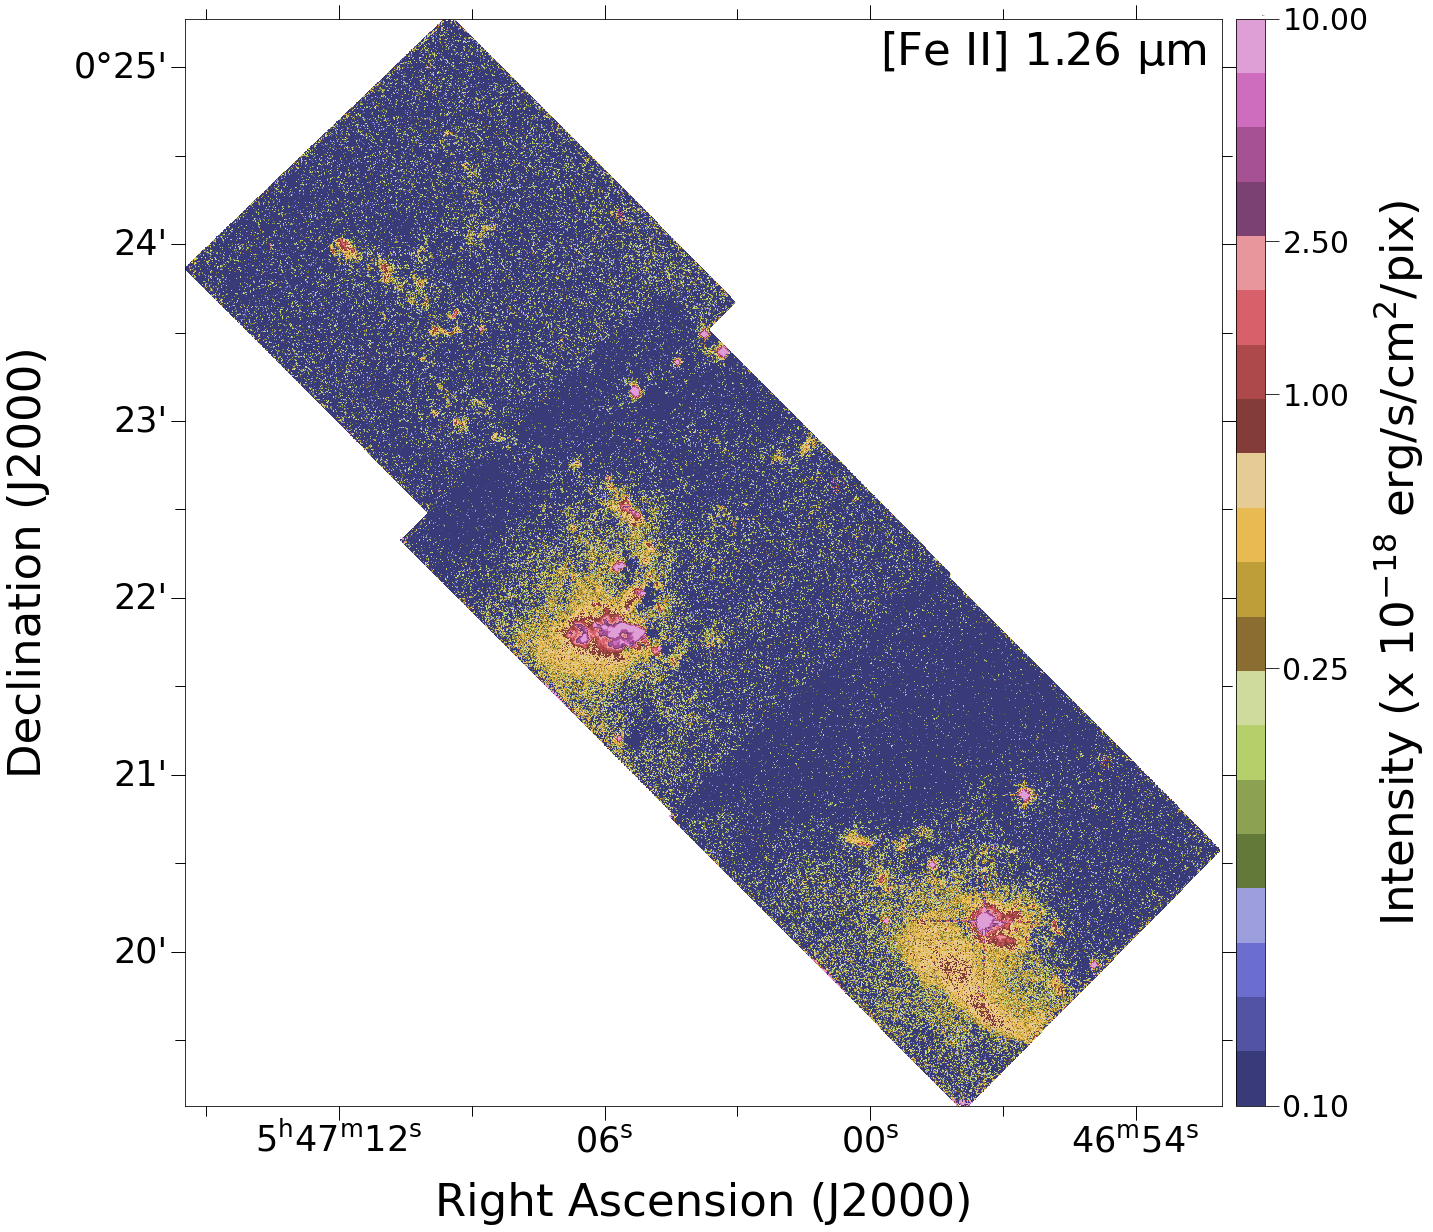

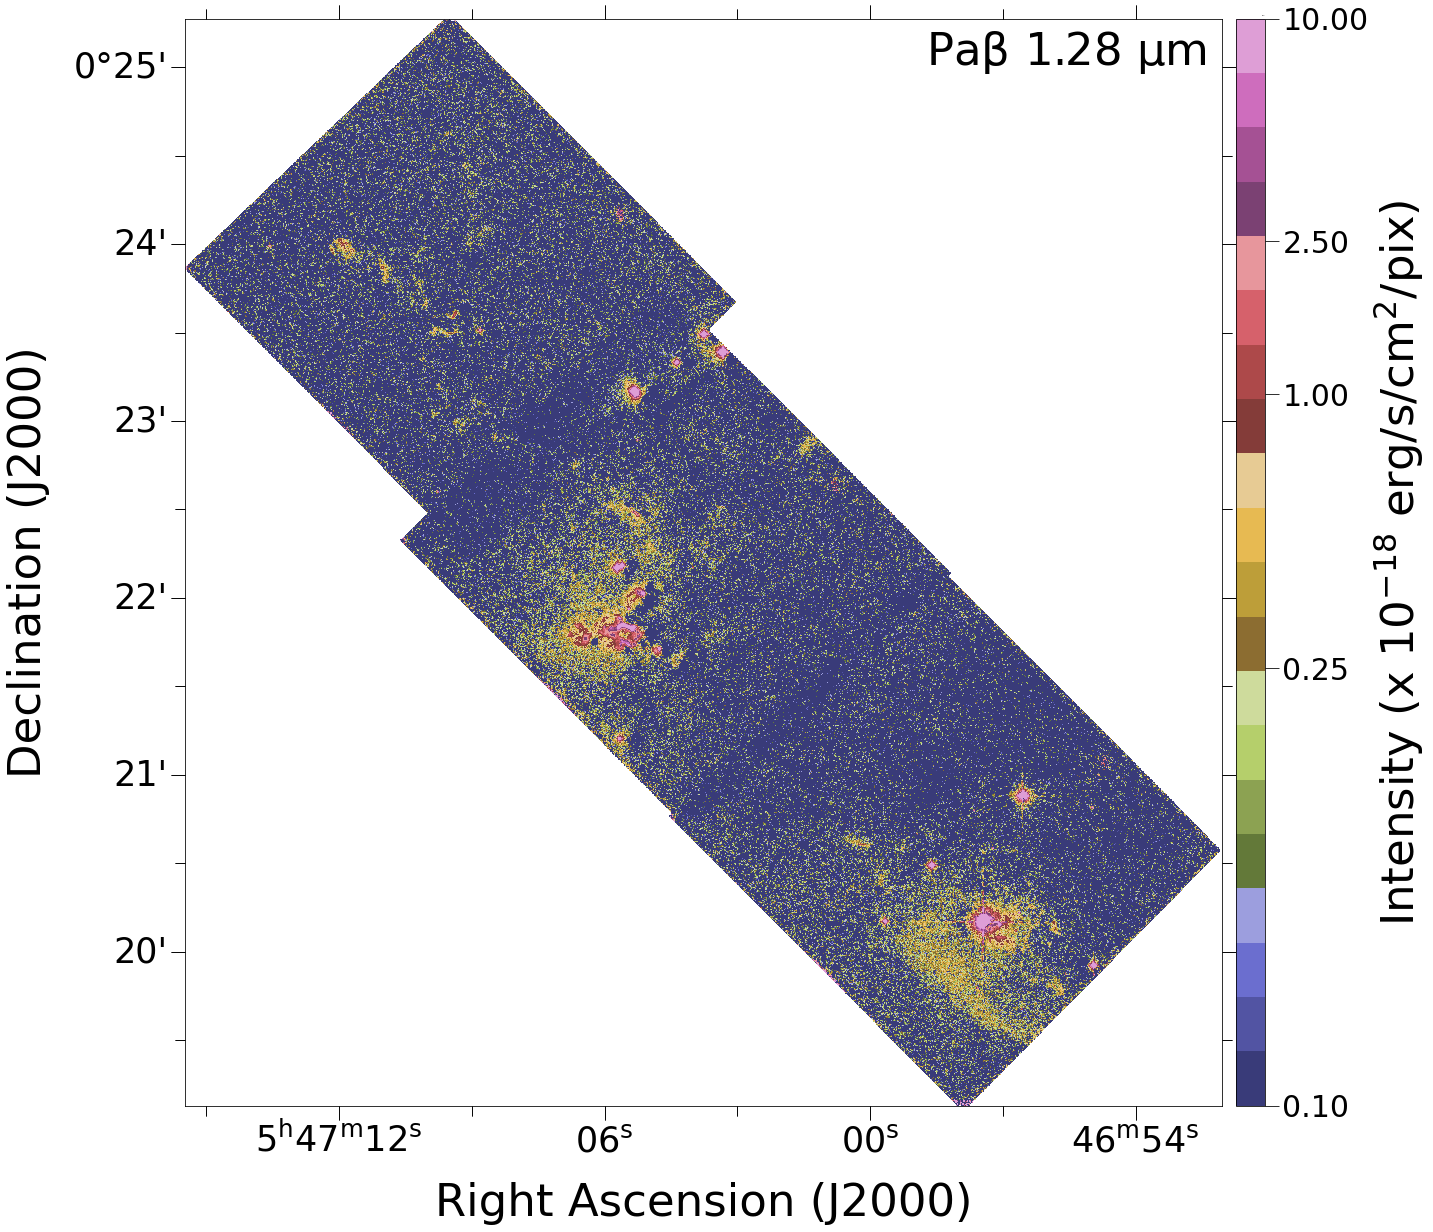

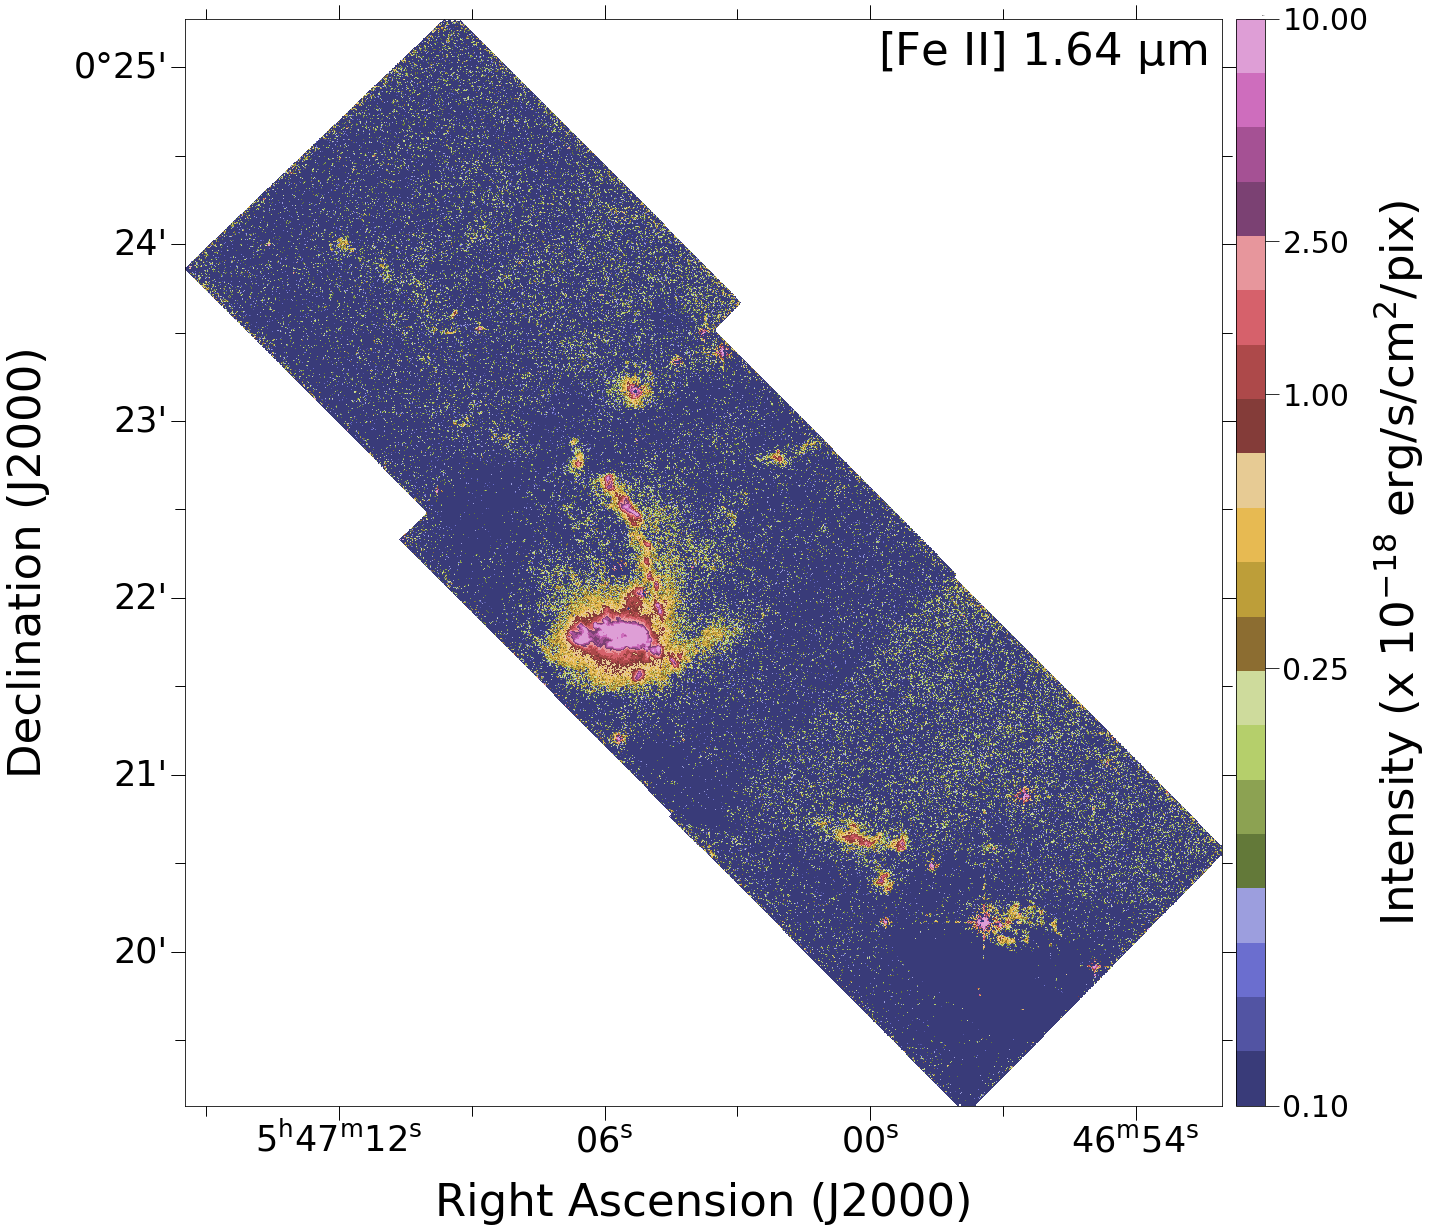

In [28]:
#plotting resulting images
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SinhStretch, LogStretch
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
import matplotlib.patches as patches
import matplotlib.ticker
from matplotlib.ticker import LogFormatter, LogLocator, FixedLocator, FixedFormatter
                
#formatting for ticks
# plt.rcParams['xtick.labeltop'] = plt.rcParams['xtick.labelright'] = False
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14

#coordinates for IRS or HOPS objects
ra_list  = ['5h47m4.785s','5h47m4.755s','5h47m4.631s','5h47m4.317s','5h47m4.623s','5h47m4.967s','5h47m5.367s','5h47m5.451s','5h47m5.125s']
dec_list = ['0d21m42.85s', '0d21m45.45s', '0d21m47.82s', '0d21m38.03s', '0d21m41.30s', '0d21m40.74s', '0d21m50.51s', '0d21m50.08s', '0d22m1.46s']
coord_sky_list = [SkyCoord(ra=i, dec=j, frame='icrs') for i,j in zip(ra_list, dec_list)]

coord_pix_list = []
for c in coord_sky_list:
    coord_pix_list.append(skycoord_to_pixel(c, WCS(montaged_header_list[0])))

#some labels we're placing on the images, then looping and plotting!
fig_names = ['126n', '128n', '164n']
detailed_fig_names = [r'$\rm [Fe\ II] \ 1.26 \ \mu m$', r'$\rm Pa\beta \ 1.28 \ \mu m$', r'$\rm [Fe\ II] \ 1.64 \ \mu m$']
for count, i in enumerate([0, 1, 2]):
    #defining the figure space
    fig, ax = plt.subplots(figsize=(20, 20))
    wcs = WCS(montaged_header_list[i])
    ax = plt.subplot(projection=wcs)
    
    #plotting
    interval = ZScaleInterval()
    data_interval = interval.get_limits(cont_subtracted_list[count]) #if you want an automatic way
    norm = ImageNormalize(stretch=LogStretch(), vmin=1e-18, vmax=100e-18) #from ds9 #automatic: vmin=data_interval[0], vmax=data_interval[1])
    im = ax.imshow(cont_subtracted_list[count], norm=norm, origin='lower', cmap='tab20b') #feel free to experiment w/cmaps
#     hops_sources = [ax.scatter(c_pair[0], c_pair[1], color='green', marker='+') for c_pair in coord_pix_list]
    
    #general formatting
#     ax.coords.grid(True, color='white', ls='solid', linewidth=0.75) #adding gridlines
    ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=45)
    ax.coords[1].set_axislabel('Declination (J2000)', fontsize=45)             
    ax.coords[0].set_minor_frequency(2) #for minor ticks
    ax.coords[1].set_minor_frequency(2)
    ax.coords[0].display_minor_ticks(True)
    ax.coords[1].display_minor_ticks(True)
    ax.tick_params(axis='x', labelbottom=True, labeltop=False, labelright=False) 
    ax.tick_params(axis='x', labelsize=35)
    ax.tick_params(axis='y', labelsize=35)
    ax.tick_params(axis='x', which='minor', length=10)
    ax.tick_params(axis='y', which='minor', length=10)
#     ax.invert_yaxis() #done because it's nicer with declination increasing going up
#     ax.invert_xaxis()
    
    #colorbar, see 3rd answer from https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    cbar = plt.colorbar(im, cax=cax) 
    
    #color bar label and tick labels
    sub_labels = [0.1, 0.25]
    cbar.locator = LogLocator(base=10, subs=sub_labels) #used to scale the colorbar because of large dynamical ranges
    cbar.ax.tick_params(labelsize=30)
    cbar.update_ticks()
    cbar.ax.yaxis.get_offset_text().set_fontsize(0)
    cbar.set_label(label=r'$\rm Intensity~(x~{10}^{-18}~erg/s/{cm}^{2}/pix)$', size=45)
    #     cbar.ax.set_yticklabels(labels=cbar.ax.get_yticklabels(), weight='normal')
#     cbar_tickfont = [cbar.ax.set_yticklabels(labels=cbar.ax.get_yticklabels())[i].set_fontweight('normal') for i in range(len(cbar.ax.get_yticklabels()))]
    for l in cbar.ax.yaxis.get_ticklabels(): #might seem odd, but otherwise the ticks end up bold somehow
        l.set_weight("normal")
    
#     #adding a compass
#     theta_wcs = (135+180+27)*np.pi/180 #might need changing
#     x, y, arrow_length = 0.87, 0.59, 0.1 #probably should experiment
#     compass_N = ax.annotate('N', xy=(x, y), xytext=(x-arrow_length*1/1.5*np.sin(theta_wcs+np.pi/3.), \
#                 y+arrow_length*2.9/2*np.cos(theta_wcs+np.pi/3.)), 
#                 arrowprops=dict(arrowstyle='<-', lw=3, color='white'), color='white',
#                 ha='center', va='center', fontsize=25, rotation=46,
#                 xycoords='subfigure fraction') #ax.transAxes)
#     compass_E = ax.annotate('E', xy=(x, y), xytext=(x-arrow_length*8/8*np.cos(theta_wcs+np.pi/2.), \
#                 y-arrow_length*10/12*np.sin(theta_wcs+np.pi/2.)), 
#                 arrowprops=dict(arrowstyle='<-', lw=3, color='white'), color='white',
#                 ha='center', va='center', fontsize=25, rotation=46,
#                 xycoords='subfigure fraction') #ax.transAxes)
    
    ax.text(2700,2750, detailed_fig_names[i], color='black', fontsize=45, \
            ha='right') #labeling the filter and line for each image
    
#     #labeling box for zoom-in
#     rect = patches.Rectangle((1550, 400), 700, 450, linewidth=2.5, edgecolor='white', facecolor='none', linestyle='--', \
#                              angle=18)
#     ax.add_patch(rect)
    
    #save
    plt.savefig(fig_names[count]+'_conv_nocont.png', dpi=300, bbox_inches='tight')
    plt.savefig(fig_names[count]+'_conv_nocont.pdf', dpi=300, bbox_inches='tight')

plt.show()